In [0]:
import pystan
import pickle
import math
import pandas as pd
import datetime
import numpy as np
from scipy import integrate
import scipy.stats as st
import pandas.tseries.offsets as offsets
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline

# 数理モデルによる実効再生産数推定
ref
- http://statmodeling.hatenablog.com/entry/covid19-estimate-effective-reproduction-number
- https://github.com/contactmodel/COVID19-Japan-Reff/blob/master/scripts/B-MLE.ipynb
- https://github.com/contactmodel/COVID19-Japan-Reff/blob/master/scripts/C.%20Calculating%20the%20Rt%20in%20Stan.ipynb
- https://www.newsweekjapan.jp/stories/world/2020/05/2-230.php
- https://natgeo.nikkeibp.co.jp/atcl/web/19/050800015/051200006/

## 実効再生産数 Rt とは



あるウイルスが1人の感染者から平均何人にうつるかを示す数値で、ウイルス感染状況の目安、数値が1なら、平均で患者1人が別の接触した1人に感染させることを意味する。


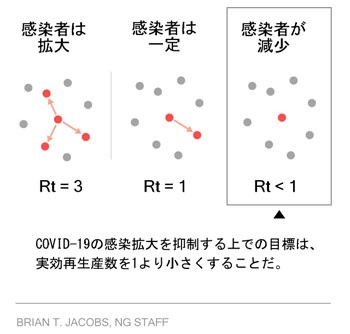

## データ集計

Data source
https://github.com/contactmodel/COVID19-Japan-Reff

In [0]:
url = "/content/drive/My Drive/covid19/JapaneseDataCOVID19 (200510).csv"
df = pd.read_csv(url)

In [0]:
df.head()

,exp_type,onset,confirmed,reported,is_asymptomatic
0,imported,2020-01-03,NaN,NaN,0.0
1,imported,2020-01-14,NaN,NaN,0.0
2,imported,2020-01-21,NaN,NaN,0.0
3,imported,2020-01-23,NaN,NaN,0.0
4,imported,2020-01-22,NaN,NaN,0.0


In [0]:
print('Number of data: ',len(df))

Number of data:  15398


まずは日付ごとの人数のデータを作ります。

- 発病日（onset）があるデータ（12526人）については発病日を使います。日付ごとに人数の合計を算出します。
- その他のデータ（2872人）については、診断日 (confirmed) または報告日（report）を報告日と呼んで、日付ごとに人数の合計を算出します。
- なお、発病日と報告日を両方持っている人は（悲しいことに）存在しません。

In [0]:
# reported と confirmed を重複なしで結合
report = []
for i in range(len(df.reported)):
  if type(df.reported[i]) == str:
    report.append(df.reported[i])
  else:
    if type(df.confirmed[i]) == str:
      report.append(df.confirmed[i])
    else:
      report.append(np.nan)
df.reported = report
df = df.drop('confirmed',axis=1)

In [0]:
df.head()

,exp_type,onset,reported,is_asymptomatic
0,imported,2020-01-03,NaN,0.0
1,imported,2020-01-14,NaN,0.0
2,imported,2020-01-21,NaN,0.0
3,imported,2020-01-23,NaN,0.0
4,imported,2020-01-22,NaN,0.0


In [0]:
df.onset = pd.to_datetime(df.onset)
df.reported = pd.to_datetime(df.reported)

In [0]:
df_im = df[df.exp_type=='imported']
df_do = df[df.exp_type=='domestic']

In [0]:
counts = df_im.groupby('onset').count().reset_index().exp_type
dates = np.sort(df_im.onset.dropna().unique())
df_im_onset = pd.DataFrame({'date':dates,'im_onset':counts})

In [0]:
counts = df_im.groupby('reported').count().reset_index().exp_type
dates = np.sort(df_im.reported.dropna().unique())
df_im_reported = pd.DataFrame({'date':dates,'im_reported':counts})

In [0]:
counts = df_do.groupby('onset').count().reset_index().exp_type
dates = np.sort(df_do.onset.dropna().unique())
df_do_onset = pd.DataFrame({'date':dates,'do_onset':counts})

In [0]:
counts = df_do.groupby('reported').count().reset_index().exp_type
dates = np.sort(df_do.reported.dropna().unique())
df_do_reported = pd.DataFrame({'date':dates,'do_reported':counts})

In [0]:
df_im = pd.merge(df_im_onset,df_im_reported,on='date',how='outer')
df_do = pd.merge(df_do_onset,df_do_reported,on='date',how='outer')

In [0]:
df_cases = pd.merge(df_im,df_do,on='date',how='outer')
df_cases = df_cases.fillna(0)
df_cases = df_cases.sort_values('date').reset_index()

安定な結果を得るために、前倒しで10日付加

In [0]:
extra_dates = []
start = df_cases.date[len(df_cases)-1]
for i in range(138): # end_date - start_date = 138 (with extra 10 days) 
  extra_dates.append(start)
  start = start - offsets.Day()

In [0]:
extra_dates = pd.DataFrame({'date':extra_dates})

In [0]:
df_cases = pd.merge(df_cases,extra_dates,on='date',how='outer')
df_cases = df_cases.fillna(0)
df_cases = df_cases.sort_values('date').reset_index()

In [0]:
dates = df_cases.date
im_onset = df_cases.im_onset
im_reported = df_cases.im_reported
do_onset = df_cases.do_onset
do_reported = df_cases.do_reported

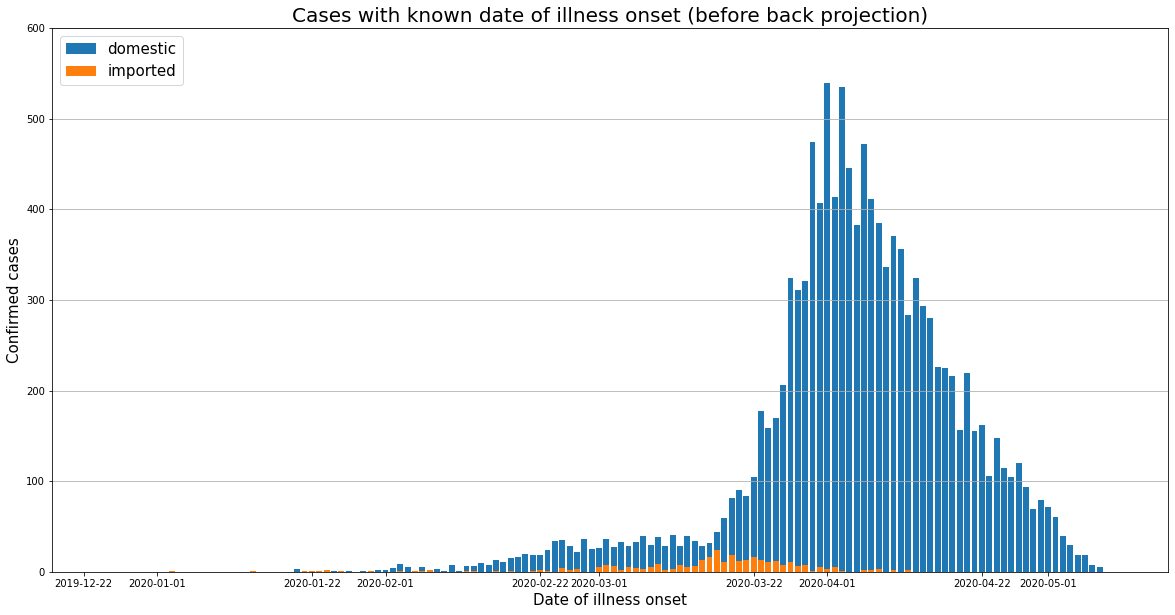

In [0]:
plt.figure(figsize=(20,10))
plt.title('Cases with known date of illness onset (before back projection)',fontsize=20)
plt.xlabel('Date of illness onset',fontsize=15)
plt.ylabel('Confirmed cases',fontsize=15)
plt.bar(dates,do_onset,label='domestic')
plt.bar(dates,im_onset,label='imported')
plt.ylim((0,600))
plt.legend(loc='upper left',fontsize=15)
plt.grid(axis='y')
plt.show()

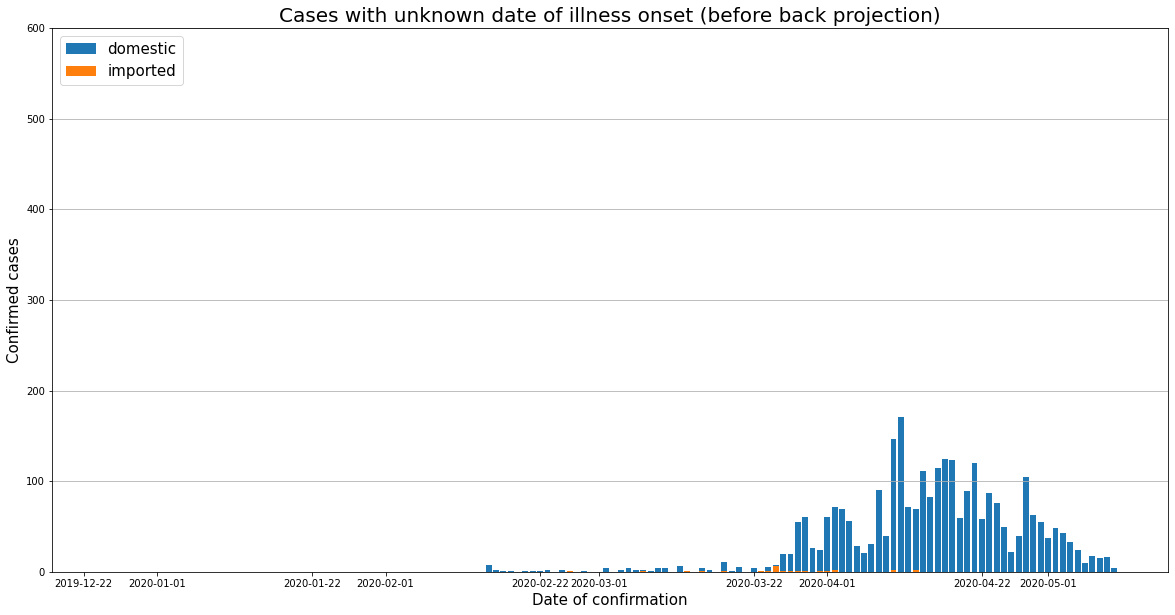

In [0]:
plt.figure(figsize=(20,10))
plt.title('Cases with unknown date of illness onset (before back projection)',fontsize=20)
plt.xlabel('Date of confirmation',fontsize=15)
plt.ylabel('Confirmed cases',fontsize=15)
plt.bar(dates,do_reported,label='domestic')
plt.bar(dates,im_reported,label='imported')
plt.ylim((0,600))
plt.legend(loc='upper left',fontsize=15)
plt.grid(axis='y')
plt.show()

## Back projection
「発病日の人数」や「報告日の人数」を「感染日の人数」に変換する。データから各人がいつ感染したのか推測する作業。
ref:
- https://www.ncbi.nlm.nih.gov/pubmed/1947509
- http://mikuhatsune.hatenadiary.com/entry/2020/05/13/205824


1. Generation time \
誰かから感染させられるー感染日：serial interval もしくはgeneration time と書いてある。厳密には違うようだが、使用しているパラメータはワイブル分布から同一のものとしている。PDFでは「世代時間<=明示的にまだ得られていない間、発病間隔と同じと想定」の項。\
In the present analysis, serial interval was assumed to be identical with generation time and the value of doubly interval censored serial interval was also adopted from the previous study (Nishiura et, al., 2020, IJID). The Weibull distribution was fitted to 28 known infector-infectee pairs (mean = 4.8 days, standard deviation = 2.3 days).


2. Incubation period\
感染日ー発症日：incubation period. 対数正規分布から平均5.6日くらいと適当に設定している（適当にというのはランダム、というわけではなく、過去の推定で当てはまりがよさそうな、という意味合いで、対数正規分布ではくワイブル分布やガンマ分布でもやれないことはない）。\
We accounted for right truncation and modeled and used a lognormal distribution with parameters adopted from an earlier study (Linton et, al., 2020, JCM), and the estimated mean and SD were 5.6 days and 3.9 days, respectively.

3. Right-truncated reporting delay\
発症日ー報告日：Right-truncated reporting delay. 打ち切りを考慮したワイブル分布を考慮している。尤度関数Lについて

  - $S_k$：kさんの報告日
  - $O_k$：kさんの発症日
  - $T$：カレンダー上の直近の観測日
  - $h$：ワイブル分布の確率密度（PDF）
  - $H$：ワイブル分布の累積確率密度（CDF）
  - $\theta$：ワイブル分布のパラメータ（shape & scale)

  We fitted the right-truncated time delay distribution from the illness onset to reporting to the Weibull distribution. We define the likelihood as follows:
  $$
  L(\theta|S_k,O_k,T)=\prod_{k=1}^{K}\frac{h(S_k-O_k  |  \theta)}{H(T-O_k  |  \theta)}
  $$
  where $S_k$ and $O_k$ are the reporting date and the date of illness onset of case $k$, respectively and $T$ is the latest calendar day of observation. $h(∙)$ and $H(∙)$ are the probability density function (PDF) and cumulative density function (CDF) of Weibull distribution and $\theta$ is the parameters of the distribution (i.e., shape and scale). The likelihood is maximized to determine the best-fit parameters used in the estimation of the reproduction number ($R_t$).

今回は3. Right-truncated reporting delay、つまり、発症日～報告日をワイブル分布で上に挙げた尤度関数Lを最大化することで得ることを目標とする。得られたパラメータをその次は有効再生産数の推定に流用する。

**ただし、最尤推定により不確実性が加味されないことになるので、有効再生産数推定のモデルの中に組み込むという案もある。←今回はこれでいく。（Back projectionでのEMSアルゴリズムがPythonではライブラリが見当たらなかった＆感染日の不確実性を有効再生産数推定にも考慮したいから）**

In [0]:
# Define distributions
def pweib(x,a,n): # cumulative
  def dt(t):
    return (a / n) * (t / n)**(a - 1) * np.exp(-(t / n)**a)
  val, _ = integrate.quad(dt,0,x)
  return val

def plnorm(x, mu, sigma): # cumulative
  shape  = sigma
  loc    = 0
  scale  = math.exp(mu)
  return st.lognorm.cdf(x, shape, loc, scale)

def dlnorm(x, mu, sigma): # density
  shape  = sigma
  loc    = 0
  scale  = math.exp(mu)
  return st.lognorm.pdf(x, shape, loc, scale)

# Discretesized distribution
T = len(df_cases)
time = np.array(range(T+1))

##------ predetermined distributions ------
## discretesized distribution of generation time (Nishiura, et al, 2020)
c_gt = [pweib(t, 2.305, 5.452) for t in time]
p_gt_rev = list(np.diff(c_gt)[::-1])


## discretesized distribution of incubation period (from infection to onset) (Linton et al 2020 - with right truncation excl. Wuhan residents)
c_inc = plnorm(time,1.519,0.615)
p_inc_rev = list(np.diff(c_inc)[::-1]) 

"""
cdf_rep <- Vectorize(function(t) {
  integrand <- function(x) {
    pweibull(t - x, shape = 1.741, scale = 8.573) * dlnorm(x, meanlog = 1.519, sdlog = 0.615)
  }
  val <- integrate(integrand, lower=0, upper=t)$value
  return(val)
})
c_rep <- cdf_rep(0:T)
p_rep_rev <- c_rep %>% diff() %>% rev()

p_rep_rev
"""
## discretesized distribution of the delay from infection to report
# right-truncated reporting delay from onset to repot (estimated values using the MHLW data): dweibull(t, shape = 1.741, scale = 8.573)
def val(t):
  def integrand(x):
    return pweib(t-x,1.741,8.573) * dlnorm(x,1.519,0.615)
  val, _= integrate.quad(integrand,0,t)
  return val

c_rep = [val(t) for t in time]
p_rep_rev = list(np.diff(c_rep)[::-1])

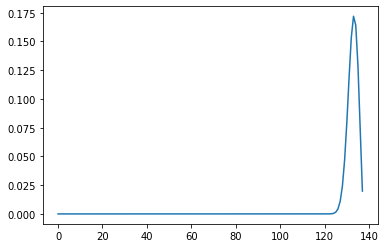

In [0]:
plt.plot(range(0,T),p_gt_rev)
plt.show()

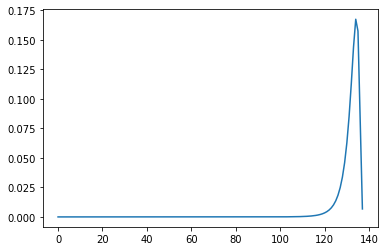

In [0]:
plt.plot(range(0,T),p_inc_rev)
plt.show()

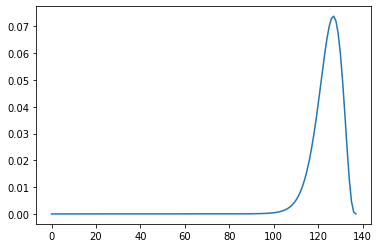

In [0]:
plt.plot(range(0,T),p_rep_rev)
plt.show()

## 実効再生産数の推定
Back projectionも推定モデルに組み込み実行


In [0]:
# Define model
model_code="""
functions {
  // calculating the convolutions
  vector convolution(vector x, vector y_rev) {
    int T = num_elements(x);
    vector[T-1] res;
    for (t in 2:T) {
      res[t-1] = dot_product(x[1:(t-1)], y_rev[(T-t+2):T]);
    }
    return res;
  }

  // continuous Poisson distribution
  real continuous_poisson_lpdf(vector y, vector lam) {
    real lp = sum(y .* log(lam) - lam - lgamma(y + 1));
    return lp;
  }
}

data {
  int<lower=1> T;       // number of days
  int<lower=0> domestic_onset[T];
  int<lower=0> imported_onset[T];
  int<lower=0> domestic_report[T];
  int<lower=0> imported_report[T];
  vector[T] p_gt_rev;   // generation time distribution (reverse order)
  vector[T] p_inc_rev;  // incubation period distribution (reverse order)
  vector[T] p_rep_rev;  // report time distribution (reverse order)
}

parameters {
  vector<lower=0>[T-1] Rt;
  real<lower=0> s_smooth;   // smoothing factor
  simplex[T] domestic_infect_from_onset_raw;  // distribution of domestic infected people from onset data
  simplex[T] imported_infect_from_onset_raw;
  simplex[T] domestic_infect_from_report_raw;
  simplex[T] imported_infect_from_report_raw;
}

transformed parameters {
  vector[T] domestic_infect_from_onset = domestic_infect_from_onset_raw * sum(domestic_onset);  // Number of domestic infected people by using back projection from onset data.
  vector[T] imported_infect_from_onset = imported_infect_from_onset_raw * sum(imported_onset);
  vector[T] domestic_infect_from_report = domestic_infect_from_report_raw * sum(domestic_report);
  vector[T] imported_infect_from_report = imported_infect_from_report_raw * sum(imported_report);

  vector[T] domestic_infect = domestic_infect_from_onset + domestic_infect_from_report;
  vector[T] imported_infect = imported_infect_from_onset + imported_infect_from_report;
  vector[T] cases_infect = domestic_infect + imported_infect;
}

model {
  // smoothing on the raw scale
  domestic_infect_from_onset_raw[2:T] ~ normal(domestic_infect_from_onset_raw[1:(T-1)], s_smooth);
  imported_infect_from_onset_raw[2:T] ~ normal(imported_infect_from_onset_raw[1:(T-1)], s_smooth);
  domestic_infect_from_report_raw[2:T] ~ normal(domestic_infect_from_report_raw[1:(T-1)], s_smooth);
  imported_infect_from_report_raw[2:T] ~ normal(imported_infect_from_report_raw[1:(T-1)], s_smooth);

  // back projection
  domestic_onset[2:T] ~ poisson(convolution(domestic_infect_from_onset, p_inc_rev));
  imported_onset[2:T] ~ poisson(convolution(imported_infect_from_onset, p_inc_rev));
  domestic_report[2:T] ~ poisson(convolution(domestic_infect_from_report, p_rep_rev));
  imported_report[2:T] ~ poisson(convolution(imported_infect_from_report, p_rep_rev));

  // estimating effective reproduction number
  domestic_infect[2:T] ~ continuous_poisson(Rt .* convolution(cases_infect, p_gt_rev));
}
"""
sm = pystan.StanModel(model_code=model_code)

# save it to the file 'model.pkl' for later use
with open('/content/drive/My Drive/covid19/model.pkl', 'wb') as f:
    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41af6b195d0a37a4a461f78cd03c2699 NOW.


In [0]:
sm = pickle.load(open('/content/drive/My Drive/covid19/model.pkl', 'rb'))

In [0]:
domestic_onset  = do_onset.astype(int).values
imported_onset  = im_onset.astype(int).values
domestic_report = do_reported.astype(int).values
imported_report = im_reported.astype(int).values  

In [0]:
# Data confirmation
print(T)
print(type(T))
print(len(domestic_onset),len(imported_onset),len(domestic_report),len(imported_report))
print(type(domestic_onset),type(imported_onset),type(domestic_report),type(imported_report))
print(len(p_gt_rev),len(p_inc_rev),len(p_rep_rev))
print(type(p_gt_rev),type(p_inc_rev),type(p_rep_rev))

138
<class 'int'>
138 138 138 138
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
138 138 138
<class 'list'> <class 'list'> <class 'list'>


In [0]:
stan_data = dict(
  T = T,
  domestic_onset  = domestic_onset,
  imported_onset  = imported_onset,
  domestic_report = domestic_report,
  imported_report = imported_report,
  p_gt_rev  = p_gt_rev,
  p_inc_rev = p_inc_rev,
  p_rep_rev = p_rep_rev
)

In [0]:
fit = sm.sampling(data = stan_data, 
                  iter = 6000,
                  warmup = 1000,
                  thin = 5,
                  n_jobs=mp.cpu_count(),
                  pars = ['Rt', 's_smooth', 'domestic_infect', 'imported_infect', 'cases_infect'],
                  seed = 1234)

## モデルと実行結果を保存＆読み込み

In [0]:
# Save & load optimized medel and results
with open('/content/drive/My Drive/covid19/model_and_result.pkl', 'wb') as f:
  pickle.dump(sm, f)
  pickle.dump(fit, f)

with open('/content/drive/My Drive/covid19/fit-summary.txt', 'w') as f:
  f.write(str(fit))

with open('/content/drive/My Drive/covid19/model_and_result.pkl', 'rb') as f:
  sm = pickle.load(f)
  fit = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


## 推定された有効再生産数$R_t$のプロット

In [0]:
# Data from past 100 days
dates = dates[-100:].values

ms = fit.extract()
Rt = ms['Rt'][:,-100:] 
ci = ms['cases_infect'][:,-100:]

Rt_med = np.quantile(Rt,0.5,axis=0)
Rt_lower = np.quantile(Rt,0.025,axis=0)
Rt_upper = np.quantile(Rt,0.975,axis=0)
ci_med = np.quantile(ci,0.5,axis=0)
ci_lower = np.quantile(ci,0.025,axis=0)
ci_upper = np.quantile(ci,0.975,axis=0)
ci_interval = (ci_upper - ci_lower) / 2

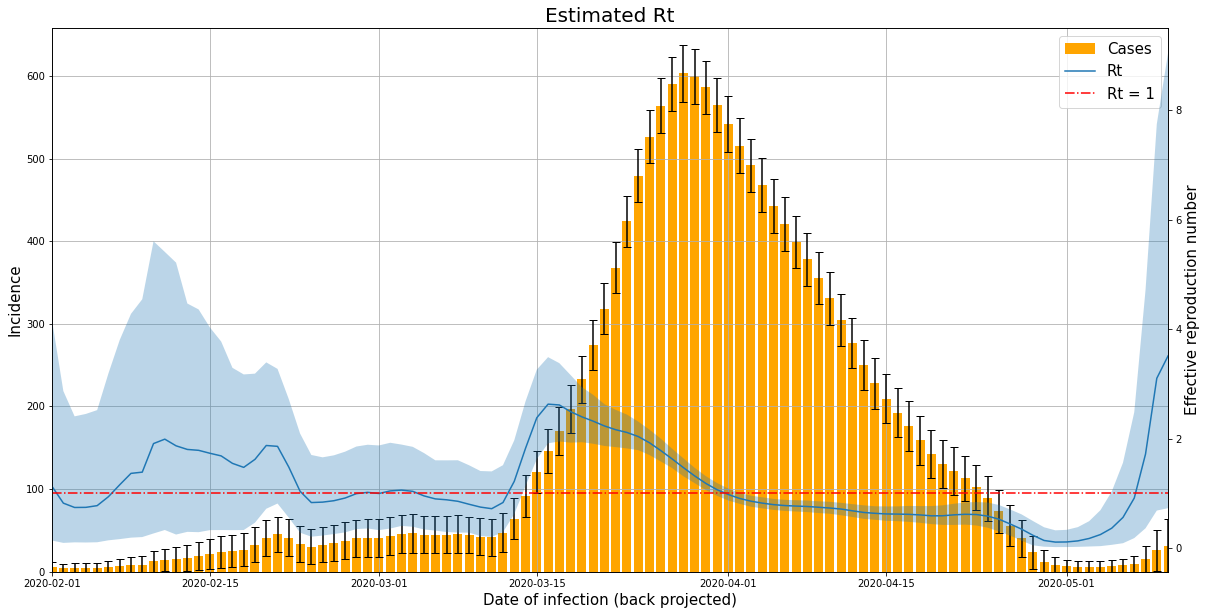

In [0]:
xmin = dates[0]
xmax = dates[-1]

fig = plt.figure(figsize=(20,10))

# plot infected cases
ax1 = fig.add_subplot(111)
ax1.set_title('Estimated Rt',fontsize=20)
ax1.set_xlim([xmin,xmax])
ax1.set_ylim((0,np.max(ci_upper)+20))
# plot quantile 2.5% ~ 97.5%
for x, y, interval in zip(dates, ci_med, ci_interval):
    ax1.errorbar(x, y, interval, capsize=4, ecolor='black')
ln1 = ax1.bar(dates, ci_med, label='Cases', color='orange')

# plot estimated Rt
ax2 = ax1.twinx()
ln2=ax2.plot(dates, Rt_med, label='Rt')
ax2.fill_between(dates, Rt_upper, Rt_lower, where=(Rt_upper >= Rt_lower), alpha=0.3, interpolate=True)
ax2.axhline(1, ls = "-.", color = "r", label='Rt = 1')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize=15)

ax1.set_xlabel('Date of infection (back projected)', fontsize=15)
ax1.set_ylabel('Incidence', fontsize=15)
ax1.grid(True)
ax2.set_ylabel('Effective reproduction number', fontsize=15)
plt.show()
